# Regression - GLMs


## Exercise 1: Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

- **FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.
- **LIVE_BAIT:** A binary variable indicating whether live bait was used.
- **CAMPER:** Whether the fishing group used a camper van.
- **PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.
- **CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (`FISH_COUNT`) by a camping group based on the values of `LIVE_BAIT`, `CAMPER`, `PERSONS` and `CHILDREN` variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort we went through to find a fish dataset for a count problem pun. 😛

In [27]:
import matplotlib.pyplot as plt 
import numpy as np 
from statsmodels.formula.api import ols
import pandas as pd
from patsy import dmatrices
import scipy.stats as sc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import seaborn as sns 
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge

import scipy.stats
import scipy.special

from math import *



from sklearn.model_selection import train_test_split

sns.set()

In [28]:
# exercise 1
df = pd.read_csv('../data/fish.csv')
df.dropna()

,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,FISH_COUNT
0,0,0,1,0,0
1,1,1,1,0,0
2,1,0,1,0,0
3,1,1,2,1,0
4,1,0,1,0,1
...,...,...,...,...,...
245,1,1,2,0,0
246,1,1,4,3,0
247,1,1,2,1,0
248,1,1,3,2,0


In [29]:
#df.LIVE_BAIT.info() #250 non-null    int64
#df.CAMPER.info() # 250 non-null    int64
#df.PERSONS.info() #250 non-null    int64
#df.CHILDREN.info() #250 non-null    int64
#df.FISH_COUNT.info() #250 non-null    int64

In [30]:
x = df[['LIVE_BAIT', 'CAMPER', 'PERSONS', 'CHILDREN']]
y = df[['FISH_COUNT']]

In [31]:
# Poisson can only be use in the case of Low MEAN <20, with VARIANCE = MEAN
#Let's check the output:
df.FISH_COUNT.unique()

array([  0,   1,   2,   5,   3,  30,  13,  11,   7,  14,  32,  22,  15,
         4, 149,  29,   8,   6,  31,   9,  65,  21,  16,  10,  38])

In [32]:
df.FISH_COUNT.describe()

count    250.000000
mean       3.296000
std       11.635028
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max      149.000000
Name: FISH_COUNT, dtype: float64

In [33]:
# MEAN = 3.3 Fishes
# Std = 11.6 Fishes
VARIANCE = (11.635028)**2
VARIANCE
# So the VARIANCE = 135.37 != MEAN => We can NOT use POISSON: 
# We can use the Negative Binomial: the variance value is free from the mean value
# we can also check with the Normal Distribution since there are reports 
#    with events occuring with an average rate λ>20
# (see below histogram)


135.373876560784

array([[<AxesSubplot:title={'center':'FISH_COUNT'}>]], dtype=object)

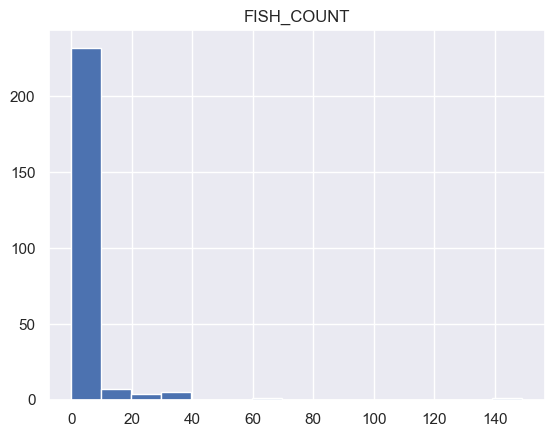

In [34]:
# Let's visualize the split of our reponse y into a histogram
y.hist(bins=15)

In [35]:
# We are in the case of a Zero inflated Model

# I - 1st Method: Built in functionality 
#     We use a method from statsmodels to evaluate the mode

# II -2nd Method: Manual implementation : the probablity a group caught any fish at all
#      we have to proceed in 2 stages: 
#            A - get the probability for the output to be Non-Zero
#            B - based on the Non-Zero Previous model, 
#                a- Here we'll check with the Negative Binomial
#                b- Then with the Normal Distribution

In [36]:
# I - Built In functionality

X = sm.add_constant(x)
model_bi = sm.ZeroInflatedPoisson(y,X).fit()
model_bi.summary()


Optimization terminated successfully.
         Current function value: 2.943385
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22


/Users/Sam/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              FISH_COUNT   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      245
Method:                            MLE   Df Model:                            4
Date:                 Tue, 21 Feb 2023   Pseudo R-squ.:                  0.3471
Time:                         13:18:31   Log-Likelihood:                -735.85
converged:                        True   LL-Null:                       -1127.0
Covariance Type:             nonrobust   LLR p-value:                5.101e-168
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.4805      0.177     -2.720      0.007      -0.827      -0.134
const            -2.5327      0.278     -9.099      0.000      -3.078      -1.987
LIVE_BAIT         1.7086      0.242      7.073      0.000       1.235       2.182
CAMPER            0.6745      0.094      7.191      0.000       0.491       0.858
PERSONS           0.8752      0.043     20.447      0.000       0.791       0.959
CHILDREN         -1.3957      0.090    -15.582      0.000      -1.571      -1.220
=================================================================================
"""

In [37]:
# II - the probablity a group caught any fish at all
# We 1st look at the probability of a group catching fishes
model_1s = sm.Logit((y>0).astype(int), sm.add_constant(x)).fit()
model_1s.summary()

Optimization terminated successfully.
         Current function value: 0.495335
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             FISH_COUNT   No. Observations:                  250
Model:                          Logit   Df Residuals:                      245
Method:                           MLE   Df Model:                            4
Date:                Tue, 21 Feb 2023   Pseudo R-squ.:                  0.2757
Time:                        13:18:32   Log-Likelihood:                -123.83
converged:                       True   LL-Null:                       -170.97
Covariance Type:            nonrobust   LLR p-value:                 1.631e-19
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1728      0.648     -4.895      0.000      -4.443      -1.902
LIVE_BAIT      0.9768      0.487      2.006      0.045       0.023       1.931
CAMPER         0.9530      0.327      2.910      0.004       0.311       1.595
PERSONS        1.1529      0.197      5.851      0.000       0.767       1.539
CHILDREN      -2.2203      0.323     -6.871      0.000      -2.854      -1.587
==============================================================================
"""

In [38]:
X_2s = pd.DataFrame(sm.add_constant(x))
X_2s['grp_catch_fish_y>0'] = model_1s.predict(X_2s)
X_2s

,const,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,grp_catch_fish_y>0
0,1.0,0,0,1,0,0.117139
1,1.0,1,1,1,0,0.477524
2,1.0,1,0,1,0,0.260569
3,1.0,1,1,2,1,0.239147
4,1.0,1,0,1,0,0.260569
...,...,...,...,...,...,...
245,1.0,1,1,2,0,0.743259
246,1.0,1,1,4,3,0.035841
247,1.0,1,1,2,1,0.239147
248,1.0,1,1,3,2,0.097549


In [39]:
X_2s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   const               250 non-null    float64
 1   LIVE_BAIT           250 non-null    int64  
 2   CAMPER              250 non-null    int64  
 3   PERSONS             250 non-null    int64  
 4   CHILDREN            250 non-null    int64  
 5   grp_catch_fish_y>0  250 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 11.8 KB


In [40]:
# B-a
model_2s = sm.NegativeBinomial(y, X_2s).fit()
model_2s.summary()

         Current function value: 1.590367
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/Users/Sam/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:             FISH_COUNT   No. Observations:                  250
Model:               NegativeBinomial   Df Residuals:                      244
Method:                           MLE   Df Model:                            5
Date:                Tue, 21 Feb 2023   Pseudo R-squ.:                  0.1439
Time:                        13:18:34   Log-Likelihood:                -397.59
converged:                      False   LL-Null:                       -464.44
Covariance Type:            nonrobust   LLR p-value:                 3.910e-27
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.1723      0.507     -6.256      0.000      -4.166      -2.178
LIVE_BAIT              2.0124      0.532      3.781      0.000       0.969       3.055
CAMPER                 1.0347      0.441      2.345      0.019       0.170       1.899
PERSONS                1.6368      0.443      3.698      0.000       0.769       2.504
CHILDREN              -2.9211      0.847     -3.448      0.001      -4.582      -1.260
grp_catch_fish_y>0    -2.8694      2.080     -1.380      0.168      -6.945       1.206
alpha                  1.9243      0.303      6.343      0.000       1.330       2.519
======================================================================================
"""

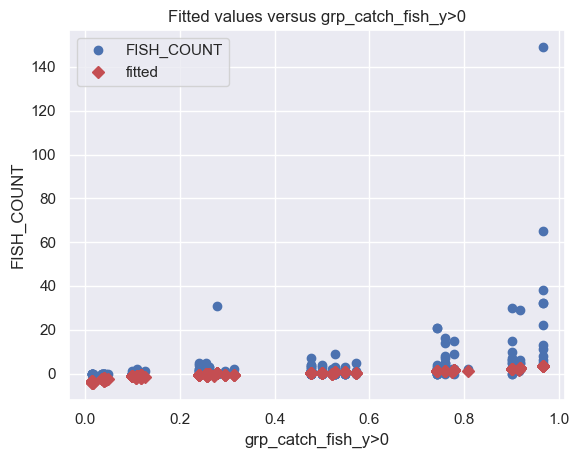

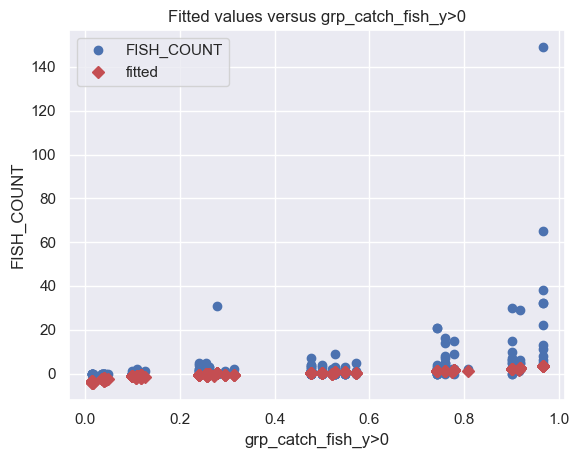

In [41]:
# the probablity a group caught any fish at all
# All coefficients are import as their Pvalues <0.05

sm.graphics.plot_fit(model_2s, 5, vlines=False) 
#2nd parameter: #exog_idx: 
# 0:const
# 1:LIVE_BAIT
# 2:CAMPER
# 3:PERSONS
# 4:CHILDREN
# 5:response for grp showing up>0   <= We are looking at this in x-axis



In [43]:
# B-b
model_2s_bis = sm.OLS(y, X_2s).fit()
model_2s_bis.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FISH_COUNT   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     13.05
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           2.90e-11
Time:                        13:18:37   Log-Likelihood:                -938.12
No. Observations:                 250   AIC:                             1888.
Df Residuals:                     244   BIC:                             1909.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -10.4807      2.556     -4.100      0.000     -15.516      -5.445
LIVE_BAIT              6.3331      2.468      2.566      0.011       1.471      11.195
CAMPER                 6.9381      2.233      3.108      0.002       2.541      11.336
PERSONS                9.5638      2.288      4.180      0.000       5.058      14.070
CHILDREN             -14.1342      3.950     -3.578      0.000     -21.915      -6.353
grp_catch_fish_y>0   -23.8062     10.774     -2.210      0.028     -45.028      -2.584
==============================================================================
Omnibus:                      420.458   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114163.931
Skew:                           8.715   Prob(JB):                         0.00
Kurtosis:                     106.228   Cond. No.                         57.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:


# Out of the 2 sub-models, the 2nd ( Normal Distribution) one has a better R-squared:
# 0.1439 vs 0.211( we pick the 2nd)



In [58]:
#sm.graphics.plot_fit(model_2s_bis, 5, vlines=False) 

In [45]:
y.shape

(250, 1)

In [46]:
X_2s.shape

(250, 6)

In [47]:
min_grp_catch_fish = X_2s['grp_catch_fish_y>0'].min()
max_grp_catch_fish = X_2s['grp_catch_fish_y>0'].max()

rng_grp = np.linspace(min_grp_catch_fish,max_grp_catch_fish, 250)

X_2s_bis = X_2s.copy()
X_2s_bis

,const,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,grp_catch_fish_y>0
0,1.0,0,0,1,0,0.117139
1,1.0,1,1,1,0,0.477524
2,1.0,1,0,1,0,0.260569
3,1.0,1,1,2,1,0.239147
4,1.0,1,0,1,0,0.260569
...,...,...,...,...,...,...
245,1.0,1,1,2,0,0.743259
246,1.0,1,1,4,3,0.035841
247,1.0,1,1,2,1,0.239147
248,1.0,1,1,3,2,0.097549


In [48]:
for col in X_2s_bis:
    X_2s_bis[col]=X_2s_bis[col].mean()
X_2s_bis

,const,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,grp_catch_fish_y>0
0,1.0,0.864,0.588,2.528,0.684,0.432
1,1.0,0.864,0.588,2.528,0.684,0.432
2,1.0,0.864,0.588,2.528,0.684,0.432
3,1.0,0.864,0.588,2.528,0.684,0.432
4,1.0,0.864,0.588,2.528,0.684,0.432
...,...,...,...,...,...,...
245,1.0,0.864,0.588,2.528,0.684,0.432
246,1.0,0.864,0.588,2.528,0.684,0.432
247,1.0,0.864,0.588,2.528,0.684,0.432
248,1.0,0.864,0.588,2.528,0.684,0.432


In [49]:
X_2s_bis = X_2s_bis.drop('grp_catch_fish_y>0', axis=1)

X_2s_bis

,const,LIVE_BAIT,CAMPER,PERSONS,CHILDREN
0,1.0,0.864,0.588,2.528,0.684
1,1.0,0.864,0.588,2.528,0.684
2,1.0,0.864,0.588,2.528,0.684
3,1.0,0.864,0.588,2.528,0.684
4,1.0,0.864,0.588,2.528,0.684
...,...,...,...,...,...
245,1.0,0.864,0.588,2.528,0.684
246,1.0,0.864,0.588,2.528,0.684
247,1.0,0.864,0.588,2.528,0.684
248,1.0,0.864,0.588,2.528,0.684


In [53]:

X_2s_bis = X_2s_bis.assign(grp_catch_fish_y=rng_grp)
X_2s_bis


,const,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,grp_catch_fish_y
0,1.0,0.864,0.588,2.528,0.684,0.013803
1,1.0,0.864,0.588,2.528,0.684,0.017630
2,1.0,0.864,0.588,2.528,0.684,0.021457
3,1.0,0.864,0.588,2.528,0.684,0.025284
4,1.0,0.864,0.588,2.528,0.684,0.029111
...,...,...,...,...,...,...
245,1.0,0.864,0.588,2.528,0.684,0.951409
246,1.0,0.864,0.588,2.528,0.684,0.955236
247,1.0,0.864,0.588,2.528,0.684,0.959063
248,1.0,0.864,0.588,2.528,0.684,0.962890


In [54]:
y_pred_2bis = model_2s_bis.predict(X_2s_bis)

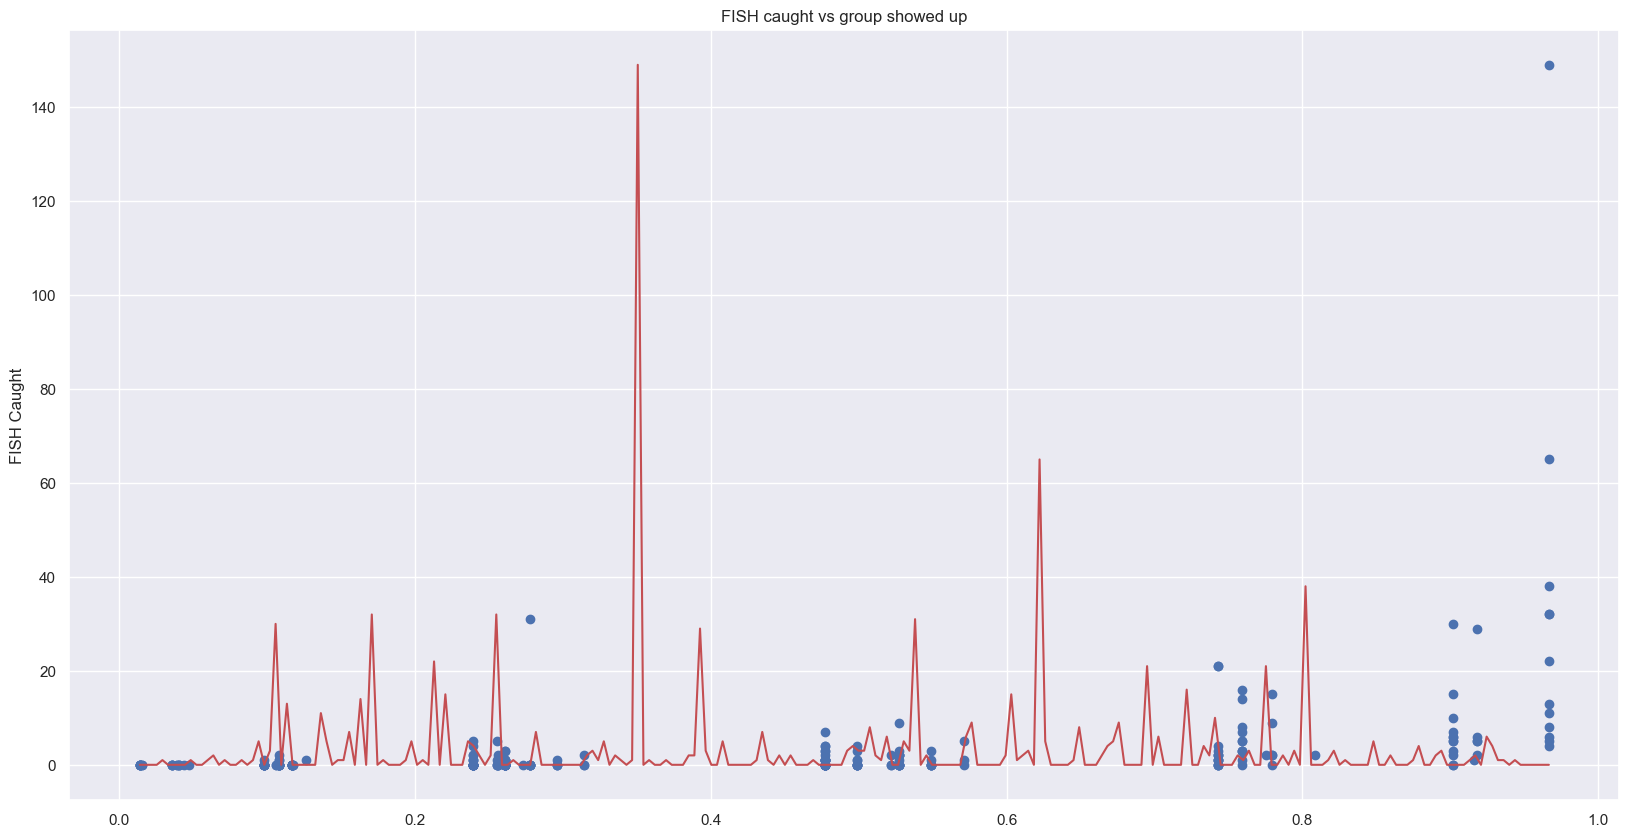

In [57]:
fig, ax = plt.subplots(figsize = (20,10))

ax.scatter(X_2s['grp_catch_fish_y>0'],y , color='b')
ax.plot( X_2s_bis['grp_catch_fish_y'],y , color='r')
ax.set_title('FISH caught vs group showed up')
ax.set_ylabel('FISH Caught')

plt.show()

In [ ]:
# The groups that have 38% of showing up, would potentially catch over 140 fishes